# Fitting of experimental chemical kinetics data
You perform some experiments in a batch reactor to determine the rate expression and thermochemistry for the reversible chemical reaction
$\require{mhchem}$
$$\ce{A <=> B}$$

Recall from thermodynamics that 
$\Delta G = \Delta H - T \Delta S$
and $\Delta G = R T \ln K_a$
where $K_a$ is the activity-based equilibrium constant of the chemical reaction, $R$ is the molar gas constant (8.314 J/mol/K) and $T$ is the temperature in Kelvin.

If we assume ideal solution (unit fugacity coefficients) then $K_a = K_c$ giving us the concentration-based equilibrium constant $K_c$. 
From kinetics you recall
$K_c = \frac{k_f}{k_r}$ 
where 
$k_f$ is the forward rate coefficient and $k_r$ is the reverse rate coefficient.
i.e. the rate of the reaction $\ce{A->B}$ is $k_f \times C_A$
and the reverse reaction $\ce{B->A}$ is $k_r \times C_B$
where $C_A$ and $C_B$ are the concentrations of species A and B respectively. 
In a batch reactor $\frac{dN_A}{dt} = r_{A(net)} V$, so (dividing through by the reactor volume $V$) $\frac{dC_A}{dt} = r_{A(net)}$ where $r_{A(net)}$ is the net rate of formation of species A, i.e. $r_{A(net)} = k_r C_B - k_f C_A$.
Assume the forward rate coefficient $k_f$ follows Arrhenius form, $k_f = A \exp\left(\frac{-E_A}{R T}\right)$ where $A$ is the "pre-exponential factor" and $E_A$ is the activation energy.

Fortunately, in this case you have good reason to believe that species A and B have very similar temperature-dependent heat capacities, so that $\Delta H_{rxn}$ and $\Delta S_{rxn}$ are independent of temperature.

You start the experiment with no B ($C_B=0$), and at time zero have some way to initiate the reaction, starting with a set concentration of $C_A$. 

You wish to determine the four paramaters:
$log_{10} A$,
$E_A$,
$\Delta H_{rxn}$,
$\Delta S_{rxn}$.

Based on a literature search, quantum chemistry calculations, and prior experience, your current estimates are as follows:
```
logA = 6.  # base-ten logarithm of A in s^-1
Ea = 45.   # Ea in kJ/mol
dH = -10.  # ∆H in kJ/mol
dS = -50.  # ∆S in J/mol/K
```


In [32]:
%matplotlib inline
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

import random
import SALib as sa
import SALib.sample
# from SALib.sample import morris as ms
# from SALib.analyze import morris as ma
# from SALib.plotting import morris as mp


ImportError: No module named 'SALib'

In [33]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("paper",rc={"figure.figsize": (2, 2)})

If you want to try different figure formatting, type 'conda install seaborn' at an anaconda command prompt or terminal. See https://stanford.edu/~mwaskom/software/seaborn/ for details


We create a "named tuple" data type to store the exprimental data in.

In [34]:
from collections import namedtuple
ExperimentData = namedtuple('ExperimentData', ['T', 'cA_start', 'times', 'cA'])

def plot_experiment(e):
    """
    Plots the experimental data provided in 'e' 
    which should be of the type ExperimentData.
    """
    plt.plot(0, e.cA_start, 'ko')
    plt.plot(e.times, e.cA,':o', label="T={:.0f}K".format(e.T))
    plt.ylim(0,)
    plt.ylabel('$C_A$ (mol/L)')
    plt.xlabel('time (s)')
    plt.legend()

Now here are the data from your three experiments:

Experiment 0 was at T=298.15K and ran for 100 seconds
Experiment 1 was at T=308.15K and ran for 100 seconds
Experiment 2 was at T=323.15K and ran for 100 seconds


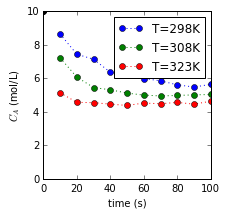

In [35]:
from numpy import array
experiments = [ExperimentData(T=298.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])), 
               ExperimentData(T=308.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])), 
               ExperimentData(T=323.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])),
              ]

for i,e in enumerate(experiments):
    print("Experiment {} was at T={}K and ran for {} seconds".format(i, e.T, e.times[-1]))
    plot_experiment(e)

At temperature of 298.15, the fitted parameters are: logA: 6.531836170971809 /s, Ea: 47411.24741318953 J/mol, dH: -3926.652750414494 J/mol, dS: -11.693256470602536 J/mol/K
At temperature of 308.15, the fitted parameters are: logA: 7.561936325150584 /s, Ea: 52903.332212834954 J/mol, dH: -7890.725019289656 J/mol, dS: -25.60897127736341 J/mol/K
At temperature of 323.15, the fitted parameters are: logA: 6.197272224030573 /s, Ea: 44058.26046679093 J/mol, dH: -13342.697077271769 J/mol, dS: -42.94094648765386 J/mol/K
The mean value of each thermal parameters at each temperature is fitted as: logA: 6.763681573384322 /s, Ea: 48124.28003093847 J/mol, dH: -8386.69161565864 J/mol, dH: -26.7477247452066 J/mol/K


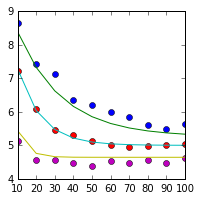

In [125]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45000. , # Ea in J/mol
    dH = -2000. , # ∆H in J/mol
    dS = -50.  # ∆S in J/mol/K
    )


# My homework begins here
# I changed the starting guess a little bit, dH changed from -10000 to -2000
# Create a new array for estimated parameters

logA_file = np.zeros(3)
Ea_file = np.zeros(3)
dH_file = np.zeros(3)
dS_file = np.zeros(3)

# Start fitting from here

for i in range (3):
    # setup the value of parameters
    C_A_0 = 10
    R = 8.314

    # Temperatures as an array
    T = [298.15, 308.15, 323.15]

    # Define a function of concentration of species A
    def function (X, logA, Ea, dH, dS):
        # Solve the thermal constants used in the equation
        t = X
        Ka = np.exp((dH - T [i] *dS) / (R* T [i]))
        k_f = 10**(logA) * np.exp(-Ea / ( R * T [i] ))
        k_r = k_f / Ka
        alpha = k_r + k_f
        # Through the integration of concentration of species A diferential equation, gives:    
        C_A = k_r * C_A_0 / alpha + (10 - 10 * k_r / alpha) * np.exp(-alpha * t) 
        return (C_A)

    X = np.array (experiments[i][2])
    Y = np.array (experiments[i][3])
    optimal_parameters, covariance  = scipy.optimize.curve_fit(function, X, Y, starting_guess)
    logA_file [i] = optimal_parameters[0]
    Ea_file [i] = optimal_parameters[1]
    dH_file [i] = optimal_parameters[2]
    dS_file [i] = optimal_parameters[3]
    
    Ka = np.exp((dH - T [i]*dS) / (R* T[i]))
    k_f = 10**(logA) * np.exp(-Ea / ( R * T[i] ))
    k_r = k_f / Ka
    alpha = k_r + k_f
    t = X
    C_A = k_r * C_A_0 / alpha + (C_A_0 - C_A_0 * k_r / alpha) * np.exp(-alpha * t)
    plt.plot(experiments[i][2], experiments[i][3], 'o')
    plt.plot(X, C_A)
    print("At temperature of {}, the fitted parameters are: logA: {} /s, Ea: {} J/mol, dH: {} J/mol, dS: {} J/mol/K". format(T[i],optimal_parameters[0], optimal_parameters[1], optimal_parameters[2], optimal_parameters[3] ))

#Calculate the mean of each parameter
logA_mean = (logA_file[0] + logA_file[1] + logA_file[2])/3
Ea_mean = (Ea_file[0] + Ea_file[1] + Ea_file[2])/3    
dH_mean = (dH_file[0] + dH_file[1] + dH_file[2])/3   
dS_mean = (dS_file[0] + dS_file[1] + dS_file[2])/3
print("The mean value of each thermal parameters at each temperature is fitted as: logA: {} /s, Ea: {} J/mol, dH: {} J/mol, dH: {} J/mol/K". format(logA_mean, Ea_mean, dH_mean, dS_mean) )


# Calculate the standard error
# 1. calculated the standard deviation
logA_std = np.std(logA_file)
Ea_std = np.std(Ea_file)
dH_std = np.std(dH_file)
dS_std = np.std(dS_file)
# 2. Calculated the standard error by deviding std sample number, in this case, sample number is equal to 3.
logA_std_err = logA_std/3
Ea_std_err = Ea_std/3
dH_std_err = dH_std/3
dS_std_err = dS_std/3


# This should end up with your optimized parameters
#optimized_parameters = ParameterSet(0,0,0,0)


# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
#standard_errors = ParameterSet(0,0,0,0)


Ok, now insert some cells to determine the optimized_parameters and their standard_errors.

In [137]:
# Finish your notebook with this cell
print(starting_guess)
print("optimized_parameters (logA = {}, Ea = {}, dH = {}, dS = {})". format(np.round(logA_mean,2), np.round(Ea_mean,2), np.round(dH_mean,2), np.round(dS_mean,2)))
print("standard_error (logA = {}, Ea = {}, dH = {}, dS = {})". format(np.round(logA_std_err,2), np.round(Ea_std_err,2), np.round(dH_std_err,2), np.round(dS_std_err,2)))

ParameterSet(logA=6.0, Ea=45000.0, dH=-2000.0, dS=-50.0)
optimized_parameters (logA = 6.76, Ea = 48124.28, dH = -8386.69, dS = -26.75)
standard_error (logA = 0.19, Ea = 1215.34, dH = 1286.68, dS = 4.26)
